In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler




In [2]:
import numpy as np
from collections import Counter

# Load the combined_labels.npy file
combined_labels_original = np.load('processed_data/combined_labels.npy', allow_pickle=True)

combined_data_original = np.load('processed_data/combined_data.npy', allow_pickle=True)

print(f"Original Shape of combined_data: {combined_data_original.shape}")
print(f"Original Shape of combined_labels: {combined_labels_original.shape}")
print(f"Original Label Counts: {Counter(combined_labels_original)}")

# --- Filter out label 8 ---
# Create a boolean mask where labels are NOT 8
mask = (combined_labels_original != 8)

# Apply the mask to both data and labels
combined_data = combined_data_original[mask]
combined_labels = combined_labels_original[mask]

print("\n--- After Filtering Label 8 ---")
print(f"New Shape of combined_data: {combined_data.shape}")
print(f"New Shape of combined_labels: {combined_labels.shape}")
print(f"New Label Counts: {Counter(combined_labels)}")

# For simplicity, assuming it's a 1D array of labels
labels = combined_labels

# Count the frequency of each label
label_counts = Counter(labels)

# Print the unique labels and their frequencies
print("Label Titles and Frequencies:")
for label, count in label_counts.most_common():
    print(f"{label}: {count}")

# Additional statistics
print("\nAdditional Statistics:")
print(f"Total number of labels: {len(labels)}")
print(f"Number of unique labels: {len(label_counts)}")

# print shape of combined_data
print("\nShape of combined_data:", combined_data.shape)

Original Shape of combined_data: (7141, 41, 22)
Original Shape of combined_labels: (7141,)
Original Label Counts: Counter({np.int32(8): 5391, np.int32(2): 821, np.int32(3): 334, np.int32(4): 298, np.int32(5): 131, np.int32(7): 87, np.int32(6): 67, np.int32(14): 12})

--- After Filtering Label 8 ---
New Shape of combined_data: (1750, 41, 22)
New Shape of combined_labels: (1750,)
New Label Counts: Counter({np.int32(2): 821, np.int32(3): 334, np.int32(4): 298, np.int32(5): 131, np.int32(7): 87, np.int32(6): 67, np.int32(14): 12})
Label Titles and Frequencies:
2: 821
3: 334
4: 298
5: 131
7: 87
6: 67
14: 12

Additional Statistics:
Total number of labels: 1750
Number of unique labels: 7

Shape of combined_data: (1750, 41, 22)


In [3]:
# --- RECOMMENDED: Add Data Scaling (MinMaxScaler) ---
# This is crucial for neural networks like LSTMs
num_features = combined_data.shape[2]
print(f"Number of features per time step: {num_features}")
print("\n--- Applying Data Scaling (MinMaxScaler) ---")
# Reshape data temporarily for scaling (MinMaxScaler expects 2D array)
original_shape = combined_data.shape
reshaped_data_for_scaler = combined_data.reshape(-1, num_features) # -1 infers batch size

scaler = MinMaxScaler(feature_range=(0, 1)) # Scale features to a [0, 1] range
scaled_data = scaler.fit_transform(reshaped_data_for_scaler)

# Reshape back to original 3D LSTM input shape
combined_data = scaled_data.reshape(original_shape)

print(f"After Scaling, Data Min: {np.min(combined_data):.4f}, Max: {np.max(combined_data):.4f}")
print(f"Data Mean: {np.mean(combined_data):.4f}, Std Dev: {np.std(combined_data):.4f}")

# Re-assign X after scaling
X = combined_data

Number of features per time step: 22

--- Applying Data Scaling (MinMaxScaler) ---
After Scaling, Data Min: 0.0000, Max: 1.0000
Data Mean: 0.4652, Std Dev: 0.1523


In [4]:
# Convert integer labels to 0-indexed integer labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(combined_labels)

print("\n--- Label Encoding Mapping ---")
# Display mapping from original label to new 0-indexed label for clarity
original_label_to_encoded_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Original Label -> Encoded Integer: {original_label_to_encoded_map}")

# Get the number of unique classes (N for 0 to N-1)
num_classes = len(np.unique(encoded_labels))
print(f"Number of unique classes (N): {num_classes}")

# Assign processed labels to Y
Y = encoded_labels


--- Label Encoding Mapping ---
Original Label -> Encoded Integer: {np.int32(2): np.int64(0), np.int32(3): np.int64(1), np.int32(4): np.int64(2), np.int32(5): np.int64(3), np.int32(6): np.int64(4), np.int32(7): np.int64(5), np.int32(14): np.int64(6)}
Number of unique classes (N): 7


In [5]:
from sklearn.model_selection import train_test_split

# Assign combined_data to X as it's already in the correct shape
X = combined_data

# Split into training and temporary (validation + test) sets
# `stratify=Y` ensures that the proportion of each class is the same in all splits
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Split the temporary set into validation and test sets
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

print(f"\n--- Data Split Shapes ---")
print(f"Training data: X_train {X_train.shape}, Y_train {Y_train.shape}")
print(f"Validation data: X_val {X_val.shape}, Y_val {Y_val.shape}")
print(f"Test data: X_test {X_test.shape}, Y_test {Y_test.shape}")


--- Data Split Shapes ---
Training data: X_train (1225, 41, 22), Y_train (1225,)
Validation data: X_val (262, 41, 22), Y_val (262,)
Test data: X_test (263, 41, 22), Y_test (263,)


In [6]:
model = Sequential()

# Define the input shape based on your data
# Assuming combined_data is a 3D array with shape (samples, timesteps, num_features)
timesteps, num_features = X_train.shape[1], X_train.shape[2]

# LSTM Layer:
# units: Number of LSTM units (neurons). You can experiment with this.
# activation: 'relu' is a common choice.
# input_shape: (timesteps, num_features) derived from your data.
model.add(LSTM(units=128, activation='relu', input_shape=(timesteps, num_features)))

# Dropout Layer:
# Helps prevent overfitting by randomly setting a fraction of input units to 0 at each update.
model.add(Dropout(0.4)) # Adjust dropout rate (e.g., 0.2 to 0.5)

# Dense Output Layer:
# units: Should be equal to the number of unique classes (8 in your case).
# activation: 'softmax' is used for multi-class classification, outputting probabilities for each class.
model.add(Dense(units=num_classes, activation='softmax'))

# Display the model summary
print("\n--- Model Architecture ---")
model.summary()


--- Model Architecture ---


c:\Users\prabh\FAU\Study\SoSe25\ADLTS\project\P3_tool_tracking_dataset\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        77,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,215 (305.53 KB)

 Trainable params: 78,215 (305.53 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Assuming 'Y' (encoded_labels) is your 0-indexed labels AFTER filtering label 8
from sklearn.utils import class_weight

# Calculate class weights
# This will automatically compute weights inversely proportional to class frequencies
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y), # Use the encoded labels here (0 to 6, as you have 7 classes now)
    y=Y
)
# Convert to a dictionary for Keras model.fit
class_weights_dict = dict(enumerate(class_weights))

print("\nCalculated Class Weights (for Focal Loss alpha):")
for encoded_val, weight in class_weights_dict.items():
    original_label = label_encoder.inverse_transform([encoded_val])[0]
    print(f"Encoded Label {encoded_val} (Original: {original_label}): Weight = {weight:.4f}")


Calculated Class Weights (for Focal Loss alpha):
Encoded Label 0 (Original: 2): Weight = 0.3045
Encoded Label 1 (Original: 3): Weight = 0.7485
Encoded Label 2 (Original: 4): Weight = 0.8389
Encoded Label 3 (Original: 5): Weight = 1.9084
Encoded Label 4 (Original: 6): Weight = 3.7313
Encoded Label 5 (Original: 7): Weight = 2.8736
Encoded Label 6 (Original: 14): Weight = 20.8333


In [8]:
def focal_loss(gamma=2.0, alpha_weights=None):
    """
    Focal loss for multi-class classification with dynamic per-class alpha.
    Assumes sparse (integer) labels for `y_true`.

    Args:
        gamma: Focusing parameter. Higher gamma reduces the loss for well-classified examples.
        alpha_weights: A dictionary or list/array of per-class alpha values (e.g., class_weights_dict).
                       If None, a uniform alpha of 0.25 is effectively applied.
    Returns:
        A Keras-compatible loss function.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Convert integer labels to one-hot for calculations
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes) # num_classes is defined globally

        # Clip predictions to prevent log(0) errors
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())

        # Calculate cross-entropy
        cross_entropy = -y_true_one_hot * tf.math.log(y_pred)

        # Calculate p_t (probability of the true class)
        # This is where the crucial `keepdims=True` ensures broadcasting works correctly.
        p_t = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1, keepdims=True)

        # Calculate (1 - p_t)^gamma
        focal_term = tf.pow(1. - p_t, gamma)

        # Apply alpha weighting:
        # Create a tensor of alpha values based on y_true
        if alpha_weights is not None:
            # Convert alpha_weights dict to a tensor
            alpha_tensor = tf.constant([alpha_weights.get(i, 1.0) for i in range(num_classes)], dtype=tf.float32)
            # Apply per-class alpha to the cross_entropy
            alpha_factor = tf.reduce_sum(y_true_one_hot * alpha_tensor, axis=-1, keepdims=True)
            loss = alpha_factor * focal_term * cross_entropy
        else:
            # If no alpha_weights provided, apply a default general alpha (like 0.25)
            loss = 0.25 * focal_term * cross_entropy # Or just focal_term * cross_entropy if you prefer no alpha

        # Sum over the classes dimension and then take mean over the batch dimension
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

    return focal_loss_fixed

# Instantiate the custom loss function with your calculated class weights
custom_focal_loss = focal_loss(gamma=2.0, alpha_weights=class_weights_dict)

print("\n--- Focal Loss Function Defined ---")
print(f"Focal Loss parameters: gamma={2.0}, alpha_weights applied per-class dynamically.")


--- Focal Loss Function Defined ---
Focal Loss parameters: gamma=2.0, alpha_weights applied per-class dynamically.



--- Starting Model Training ---
Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1170 - loss: 1.4607 - val_accuracy: 0.2481 - val_loss: 1.2919
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2917 - loss: 1.2216 - val_accuracy: 0.0725 - val_loss: 1.1951
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1557 - loss: 1.1062 - val_accuracy: 0.3817 - val_loss: 1.0331
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2881 - loss: 1.1369 - val_accuracy: 0.2634 - val_loss: 1.2638
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3460 - loss: 1.1464 - val_accuracy: 0.5153 - val_loss: 0.8315
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4558 - loss: 0.8647 - val_accuracy: 0.4198 - val_loss: 0.7810
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3839 - loss: 0.8343 - val_accuracy: 0.4351 - val_loss: 0.6217
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4771 

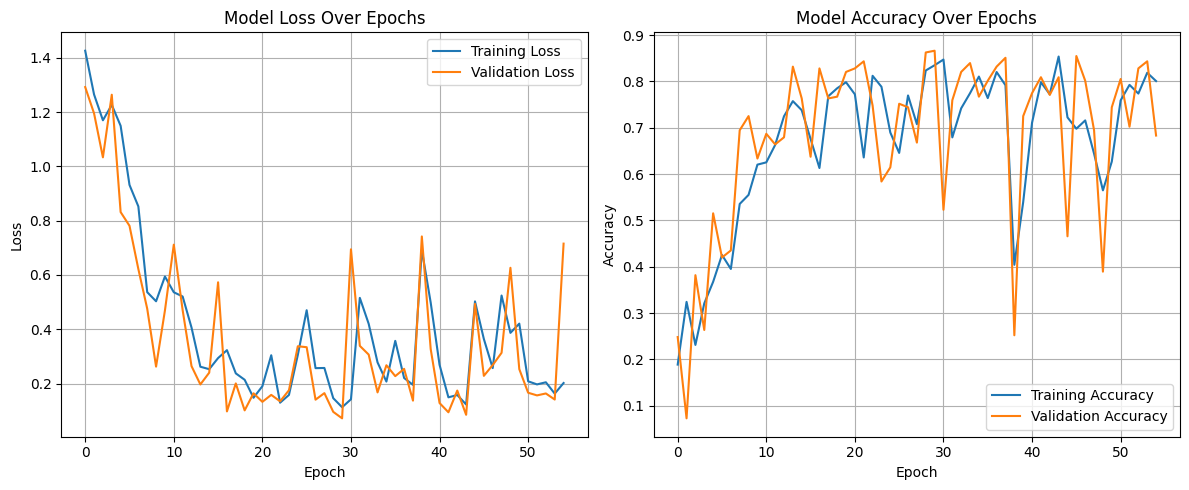

In [9]:
from tensorflow.keras.optimizers import Adam

# Compile the model
# optimizer: 'adam' is a good general-purpose optimizer.
# loss: 'sparse_categorical_crossentropy' for integer-encoded multi-class labels.
# metrics: 'accuracy' to monitor classification accuracy during training.
optimizer = Adam(learning_rate=0.001) # You can adjust the learning rate if needed
model.compile(optimizer=optimizer,
              loss=custom_focal_loss, # Use the custom focal loss function
              metrics=['accuracy'])

# Define Early Stopping callback
# Monitor 'val_loss' (validation loss) to stop training if it doesn't improve.
# patience: number of epochs with no improvement after which training will be stopped.
# restore_best_weights: True to load the weights from the epoch with the best validation loss.
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)

print("\n--- Starting Model Training ---")
history = model.fit(
    X_train, Y_train,
    epochs=100, # Set a sufficiently high number; EarlyStopping will manage when to stop
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping], # Include the early stopping callback
    verbose=1 # Show training progress
)

# --- Visualize Training History ---
print("\n--- Training History Plots ---")
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
# --- Make Predictions ---
# Let's predict on the first 5 samples from our training data as an example
num_predictions_to_show = 5
sample_for_prediction = X_train[:num_predictions_to_show]
actual_values = Y_train[:num_predictions_to_show]

predictions = model.predict(sample_for_prediction)

print(f"--- Predictions for the first {num_predictions_to_show} samples ---")
print("Actual values:")
print(actual_values.flatten()) # .flatten() for cleaner output if Y_train was 2D
print("\nPredicted values:")
print(predictions.flatten())

# You might want to inverse scale predictions if you scaled your Y_train
# if 'scaler_Y' in globals() and scaler_Y is not None:
#     predictions_unscaled = scaler_Y.inverse_transform(predictions)
#     print("\nPredicted values (unscaled):")
#     print(predictions_unscaled.flatten())


# --- Evaluate the Model (on a separate test set if available) ---
# For demonstration, we'll evaluate on the entire training data (not ideal for real world)
# If you have X_test, Y_test, use them here.
#
# loss = model.evaluate(X_test, Y_test, verbose=0)
# print(f"\nTest Loss: {loss}")

# For our dummy data:
loss_on_train = model.evaluate(X_train, Y_train, verbose=0)

print(f"\nLoss on Training Data: {loss_on_train[0]}")
print(f"Accuracy on Training Data: {loss_on_train[1]}")
# Save the model
model.save('lstm_model.h5')
print("\n--- Model Saved as 'lstm_model.h5' ---")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
--- Predictions for the first 5 samples ---
Actual values:
[4 0 1 1 0]

Predicted values:
[4.1298591e-23 1.0764101e-30 4.3632208e-28 4.5323092e-28 1.0000000e+00
 1.8009781e-14 5.9256556e-26 6.9232416e-01 8.2776940e-05 3.0720010e-01
 2.3776376e-04 7.2260838e-05 1.8011606e-05 6.4908578e-05 2.1914100e-06
 5.8260679e-01 6.2871404e-05 4.1724995e-01 1.5990431e-06 7.4943960e-06
 6.9044938e-05 3.3915654e-07 5.8303779e-01 1.3932903e-05 4.1691759e-01
 2.7151989e-07 1.9385977e-06 2.8125811e-05 6.9017190e-01 1.8087312e-05
 3.0971411e-01 6.7371089e-05 1.2639617e-05 3.8127107e-06 1.2104086e-05]



Loss on Training Data: 0.08827323466539383
Accuracy on Training Data: 0.8914285898208618

--- Model Saved as 'lstm_model.h5' ---



--- Evaluating Model on Test Set ---
Test Loss: 0.0676
Test Accuracy: 0.9011
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  

--- Classification Report (on Test Set) ---
              precision    recall  f1-score   support

           2       0.92      0.95      0.94       123
           3       0.88      0.92      0.90        50
           4       0.88      0.78      0.82        45
           5       0.78      0.70      0.74        20
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        13
          14       0.67      1.00      0.80         2

    accuracy                           0.90       263
   macro avg       0.88      0.91      0.89       263
weighted avg       0.90      0.90      0.90       263



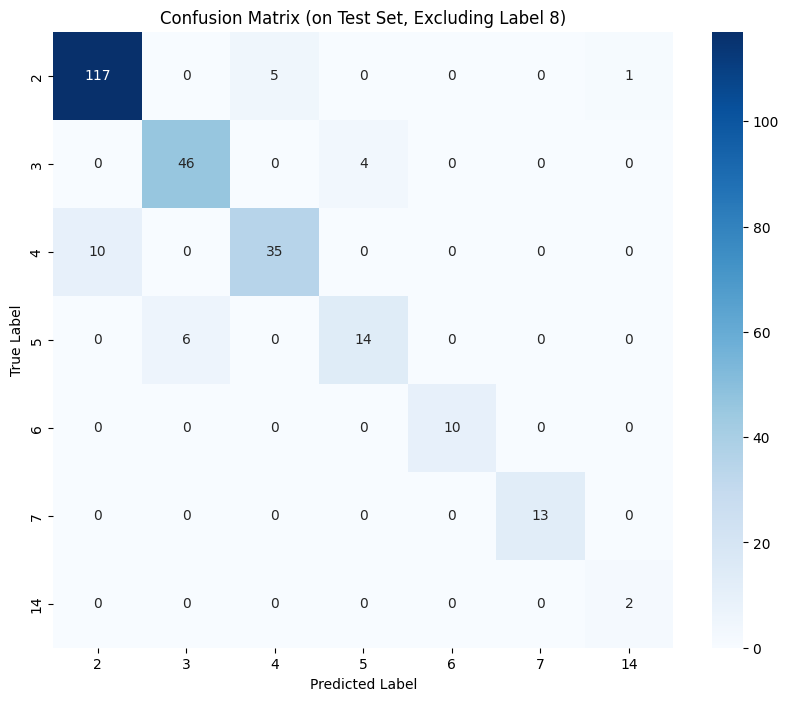

In [11]:
import seaborn as sns

print("\n--- Evaluating Model on Test Set ---")
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions (probabilities for each class)
Y_pred_probs = model.predict(X_test)
# Convert probabilities to class predictions (the class with the highest probability)
Y_pred_encoded = np.argmax(Y_pred_probs, axis=1)

# Decode predictions and true labels back to original format for better interpretability
Y_test_original = label_encoder.inverse_transform(Y_test)
Y_pred_original = label_encoder.inverse_transform(Y_pred_encoded)

print("\n--- Classification Report (on Test Set) ---")
# `target_names` ensures the report uses your original label values (e.g., '2', '3', '14')
print(classification_report(Y_test_original, Y_pred_original, target_names=label_encoder.classes_.astype(str)))

# --- Confusion Matrix ---
cm = confusion_matrix(Y_test_original, Y_pred_original)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_.astype(str),
            yticklabels=label_encoder.classes_.astype(str))
plt.title('Confusion Matrix (on Test Set, Excluding Label 8)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()